# Creating a colored structure widget
The `dms_struct.struct_widget` module implements utility functions to simplify using [nglview](https://github.com/arose/nglview) to create [Jupyter widgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html) that show protein structures colored by some site-specific metric.
Here we use this module to generate views of a H3 influenza hemagglutinin (HA) colored by the site-specific serum immune selection measured in a mutational antigenic profiling experiment.

## Import Python modules

In [1]:
from IPython.display import display, Image

import pandas as pd

import yaml

from dms_struct.colorschemes import ValueToColorMap
from dms_struct.struct_widget import colored_struct

## Immune selection data for coloring
We will color each site in HA according to the immune selection imposed by human serum as measured in mutational antigenic profiling.
Those immune selection data are in the file [data/Lee_serum_mapping.csv](data/Lee_serum_mapping.csv).
Read them into a data frame and get just the values for the specific serum sample of interest (*2010-age-21*):

In [2]:
data = (pd.read_csv('data/Lee_serum_mapping.csv')
        .query('serum == "2010-age-21"')
        .reset_index(drop=True)
        )

data.head()

,serum,serum_group,site,isite,pdb_chain,pdb_site,zoom_site,wildtype,mutation,mutdiffsel,positive_diffsel,negative_diffsel,abs_diffsel
0,2010-age-21,human,193,208,A,193,True,F,D,3.6671,15.837,-1.5467,17.384
1,2010-age-21,human,193,208,A,193,True,F,N,3.1793,15.837,-1.5467,17.384
2,2010-age-21,human,193,208,A,193,True,F,Q,2.0820,15.837,-1.5467,17.384
3,2010-age-21,human,193,208,A,193,True,F,E,2.0098,15.837,-1.5467,17.384
4,2010-age-21,human,193,208,A,193,True,F,L,1.0960,15.837,-1.5467,17.384


The data frame above has the differential selection for each mutation (*mutdiffsel*).
We can only plot one number per residue in the structure, which will be the total positive differential selection at that site (*positive_diffsel*).
So we subset to a data frame that has just:
  - The PDB chain for each site (A is for HA1, B is for HA2) in [PDB 4o5n](https://www.rcsb.org/structure/4O5N)
  - The site number in H3 numbering, which is the scheme used by [PDB 4o5n](https://www.rcsb.org/structure/4O5N)
  - Whether or not the site is one that we will "zoom" (or highlight); these are the sites of strongest selection
  - The immune selection (*positive_diffsel*) at the site

In [3]:
prop_df = (data
           [['pdb_chain', 'pdb_site', 'zoom_site', 'positive_diffsel']]
           .drop_duplicates()
           .reset_index(drop=True)
           )
print(f"We have data for {len(prop_df)} sites.")

We have data for 566 sites.


We now need to map the immune selection values to colors for the PDB coloring.
We first generate a `dms_struct.colorschemes.ValueToColorMap`, which we scale to go from the lowest to highest observed *positive_diffsel* in our data set.
We then print the scale bar for the immune selection to color mapping:

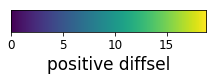

In [4]:
colormapper = ValueToColorMap(prop_df['positive_diffsel'].min(),
                              prop_df['positive_diffsel'].max())

_ = colormapper.scale_bar(label='positive diffsel', orientation='horizontal')

Now we add a column to our data frame that gives the color as calculated from the immune selection:

In [5]:
prop_df = prop_df.assign(color=lambda x: (x['positive_diffsel']
                                          .apply(colormapper.val_to_color)
                                          )
                         )

prop_df.head()

,pdb_chain,pdb_site,zoom_site,positive_diffsel,color
0,A,193,True,15.8370,#95d73f
1,A,144,True,9.9572,#1e978a
2,A,159,True,11.6170,#26ac81
3,A,160,True,4.6819,#3b518a
4,A,135,False,3.0065,#453681


## Create structure widgets

We are now going to create a widget for the H3 HA structure in [PDB 4o5n](https://www.rcsb.org/structure/4O5N).

We would like to initially show the structure in a pre-defined "vertical trimer" orientation that we manually determined is a good way to view the structure.
We will read that orientation into a dict from the YAML file [data/pdb_orientations.yaml](data/pdb_orientations.yaml), which contains a variety of different orientations.
(If you want to create a new orientation by manually manipulating a widget, follow the [steps here](https://github.com/arose/nglview/issues/785#issuecomment-487409212)):

In [6]:
with open('data/pdb_orientations.yaml') as f:
    orientation = yaml.safe_load(f)['4o5n']['vertical_trimer']

Now we use `dms_struct.struct_widget.colored_struct` to get a widget in the default (cartoon) representation, colored according to the colors listed in our data frame `prop_df`, and then show that widget:

In [7]:
w_cartoon = colored_struct(
                pdb='4o5n',
                prop_df=prop_df,
                chain_col='pdb_chain',
                site_col='pdb_site',
                orientation=orientation,
                )
w_cartoon

NGLWidget()

While the above widget does show the colored sites of immune selection on the HA head, they are hard to see.
To make them more visible, we can also specify `highlight_col` to create a widget in which the sites indicated in that column in the `prop_df` data frame are shown in spacefill representation:

In [8]:
w_cartoon_ball = colored_struct(
                    pdb='4o5n',
                    prop_df=prop_df,
                    chain_col='pdb_chain',
                    site_col='pdb_site',
                    highlight_col='zoom_site',
                    orientation=orientation,
                    )
w_cartoon_ball

NGLWidget()

This makes the selected sites of selection much more visible.

We can also create a widget that shows a surface representation as below:

In [9]:
w_surface = colored_struct(
                pdb='4o5n',
                prop_df=prop_df,
                representation='surface',
                chain_col='pdb_chain',
                site_col='pdb_site',
                orientation=orientation,
                )
w_surface

NGLWidget()

We can also show just some of the structure; for instance, below we show just HA1 (chain *A*):

In [10]:
w_ha1 = colored_struct(
                pdb='4o5n',
                prop_df=prop_df.query('pdb_chain == "A"'),
                chain_col='pdb_chain',
                site_col='pdb_site',
                highlight_col='zoom_site',
                orientation=orientation,
                )
w_ha1

NGLWidget()

We can also show other parts of the structure outside of the specified chain in a different color.
Below we show HA1 (chain A) according to `prop_df`, and then show the other protein chains (in this case HA2, chain B) simply in gray:

In [11]:
w_ha2gray = colored_struct(
                pdb='4o5n',
                prop_df=prop_df.query('pdb_chain == "A"'),
                chain_col='pdb_chain',
                site_col='pdb_site',
                highlight_col='zoom_site',
                show_other='protein',
                other_color='gray',
                orientation=orientation,
                )
w_ha2gray

NGLWidget()

## Saving static images
Although [nglview](https://github.com/arose/nglview) is designed to show interactive widgets as above, it is possible to also save static images to files.
Here we illustrate the basic process, which is detailed [here](https://github.com/arose/nglview/issues/785#issuecomment-492083727).

Note that if you run the notebook all at once without pausing between cells, then this may not work. You need to run the above cells and give the widgets time to render in the notebook before using the following commands.

First, we render the image, using `factor` to control the quality (higher value is better quality):

In [12]:
w_cartoon_ball.render_image(antialias=False, factor=3, trim=True)
w_cartoon_ball.center()

Next, we get the image:

In [13]:
image = w_cartoon_ball._display_image()

Finally, write the image to a file and then display it:

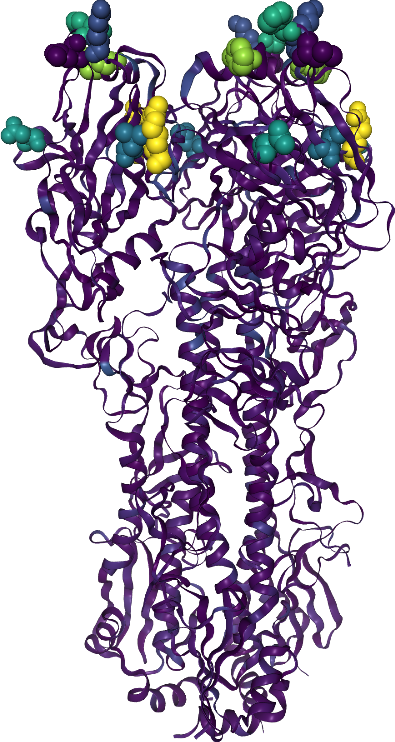

In [14]:
with open('_temp_image.png', 'wb') as f:
    f.write(image.data)
display(Image('_temp_image.png'))